In [1]:
import sympy as sp
import numpy as np
import mainframe as mf
import nuclei_func as nf
from mainframe import Region
from IPython.display import display, Latex

In [2]:
################################################################################
# Cross section data
################################################################################
micro_abs_water = nf.mixture([0.33, 4.2],[2, 1]) 
micro_abs_U235 = 101 
micro_fiss_U235 = 678 

density_water = 1
density_U235 = 19.1

T_new = 60
T_correction = np.sqrt(293/(T_new+273))

macro_abs_water = nf.macro(micro_abs_water, density_water, 18) * T_correction
macro_abs_U235 = nf.macro(micro_abs_U235, density_U235, 235) * T_correction
macro_fiss_U235 = nf.macro(micro_fiss_U235, density_U235, 235) * T_correction

qual = sp.symbols('qual', positive=True, real=True)

macro_abs_refl = nf.mixture([macro_abs_water, 0], [1, 0])
macro_fiss = nf.mixture([macro_fiss_U235, 0], [qual, 1-qual])
macro_abs_core = nf.mixture([macro_abs_water, macro_abs_U235], [1-qual, qual])

display(Latex(r'$\Sigma_{f} = ' + sp.latex(macro_fiss) + r'$'))
display(Latex(r'$\Sigma_{a, core} = ' + sp.latex(macro_abs_core) + r'$'))
display(Latex(r'$\Sigma_{a, refl} = ' + sp.latex(macro_abs_refl) + r'$'))

The sum of the qualites values is not 1, at line 4, default behaviour is ignoring.


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [3]:
############################################################################################################
# INPUT EXAMPLE
############################################################################################################
Reflector_SX = Region(0.16, macro_abs_refl, 0, 0, 60, -sp.oo, 0, 'r')
Core = Region(0.16, macro_abs_core, macro_fiss, 2.44, 60, 0, 50, 'c', 25*50)
Reflector_DX = Region(0.16, macro_abs_refl, 0, 0, 60, 50, sp.oo, 'r')
regions = [Core, Reflector_DX]

In [4]:
# Solving the problem
# Capture output to hide debug prints
# from IPython.utils.io import capture_output

# with capture_output() as captured:
#     equations, fluxes, boundaries, interfaces, powers = mf.main(regions)


In [5]:
equations, fluxes, boundaries, interfaces, powers = mf.main(regions)

Region 2 is a reflector
The region 1 spanning from 0 to 50 is a boundary region
Applying boundary condition at x = 0
Flux goes to C_2 at x = 0
The region 2 spanning from 50 to oo is a boundary region
Applying boundary condition at x = oo
Term C_4*cosh((x - 50)/L_2) has infinity at x = oo
The regions 1 and 2 are adjacent at 50
Diffusion equations:
Eq(Bg_1**2*phi_1(x) + Derivative(phi_1(x), (x, 2)), 0)
Eq(Derivative(phi_2(x), (x, 2)) - phi_2(x)/L_2**2, 0)

Fluxes:
Eq(phi_1(x), C_1*sin(Bg_1*x) + C_2*cos(Bg_1*x))
Eq(phi_2(x - 50), -C_3*sinh((x - 50)/L_2) + C_4*cosh((x - 50)/L_2))

Boundary conditions:
Eq(C_2, 0)
Eq(C_4, 0)

Interface conditions:
Eq(C_1*sin(Bg_1*x_1) + C_2*cos(Bg_1*x_1), -C_3*sinh((x_1 - 50)/L_2) + C_4*cosh((x_1 - 50)/L_2))
Eq(-D_1*(Bg_1*C_1*cos(50*Bg_1) - Bg_1*C_2*sin(50*Bg_1)), C_3*D_2/L_2)

Power conditions:
Eq(1.05479608235362e-9*qual*(-C_1*cos(50*Bg_1)/Bg_1 + C_1/Bg_1 + C_2*sin(50*Bg_1)/Bg_1), 1250)


In [6]:
# Print the equations
print('Diffusion equations:')
for eq in equations:
    display(Latex("$" + sp.latex(eq) + "$"))

Diffusion equations:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [7]:
# Print the fluxes
print('\nFluxes:')
for flux in fluxes:
    display(Latex("$" + sp.latex(flux) + "$"))


Fluxes:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [8]:
# Print the boundary conditions
print('\nBoundary conditions:')
for boundary in boundaries:
    display(Latex("$" + sp.latex(boundary) + "$"))


Boundary conditions:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [9]:
# Print the interface conditions
print('\nInterface conditions:')
for interface in interfaces:
    display(Latex("$" + sp.latex(interface) + "$"))


Interface conditions:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [10]:
# Print the power conditions
print('\nPower conditions:')
for power in powers:
    display(Latex("$" + sp.latex(power) + "$"))


Power conditions:


<IPython.core.display.Latex object>

In [11]:
# Discard all the equations that are Flase or True
fluxes = [eq for eq in fluxes if eq != False and eq != True]
boundaries = [eq for eq in boundaries if eq != False and eq != True]
interfaces = [eq for eq in interfaces if eq != False and eq != True]
powers = [eq for eq in powers if eq != False and eq != True]


# Call the compute function
system = mf.compute(fluxes, boundaries, interfaces, powers, regions)
print('\nSimplified system:')
for eq in system:
    display(Latex("$" + sp.latex(eq) + "$"))

Region 1 has B = 21.134566974928*sqrt(qual - 0.00213407421304458)
Region 2 has B = 0.976333324543103*I
Substituting {C_2: 0, C_4: 0} in Eq(phi_1(x), C_1*sin(21.134566974928*x*sqrt(qual - 0.00213407421304458)) + C_2*cos(21.134566974928*x*sqrt(qual - 0.00213407421304458))) gives Eq(phi_1(x), C_1*sin(21.134566974928*x*sqrt(qual - 0.00213407421304458)))
Substituting {C_2: 0, C_4: 0} in Eq(phi_2(x - 50), -C_3*sinh(0.976333324543103*x - 48.8166662271552) + C_4*cosh(0.976333324543103*x - 48.8166662271552)) gives Eq(phi_2(x - 50), -C_3*sinh(0.976333324543103*x - 48.8166662271552))
Substituting {C_2: 0, C_4: 0} in Eq(C_1*sin(1056.7283487464*sqrt(qual - 0.00213407421304458)) + C_2*cos(1056.7283487464*sqrt(qual - 0.00213407421304458)), C_4) gives Eq(C_1*sin(1056.7283487464*sqrt(qual - 0.00213407421304458)), 0)
Substituting {C_2: 0, C_4: 0} in Eq(-3.38153071598849*C_1*sqrt(qual - 0.00213407421304458)*cos(1056.7283487464*sqrt(qual - 0.00213407421304458)) + 3.38153071598849*C_2*sqrt(qual - 0.0021340

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [12]:
# Get all the unkowns
all_symbols = set()
for eq in system:
    all_symbols.update(eq.free_symbols)

x = sp.symbols('x')
all_symbols.discard(x)

unkowns = [flux.lhs for flux in fluxes]
for i in all_symbols:
    unkowns.append(i)

display(unkowns)
display(system)

[phi_1(x), phi_2(x - 50), C_3, C_1, qual]

[Eq(phi_1(x), C_1*sin(21.134566974928*x*sqrt(qual - 0.00213407421304458))),
 Eq(phi_2(x - 50), -C_3*sinh(0.976333324543103*x - 48.8166662271552)),
 Eq(C_1*sin(1056.7283487464*sqrt(qual - 0.00213407421304458)), 0),
 Eq(-3.38153071598849*C_1*sqrt(qual - 0.00213407421304458)*cos(1056.7283487464*sqrt(qual - 0.00213407421304458)), 0.156213331926896*C_3),
 Eq(1.05479608235362e-9*qual*(-0.0473158499621166*C_1*cos(1056.7283487464*sqrt(qual - 0.00213407421304458))/sqrt(qual - 0.00213407421304458) + 0.0473158499621166*C_1/sqrt(qual - 0.00213407421304458)), 1250)]

In [13]:
# Identify the core region
for region in regions:
    if region.Composition == 'c':
        core = region

material_buckling = (core.Nu * macro_fiss - macro_abs_core) / core.Diffusion
width = core.End - core.Start
extrapolation_length = width + 0.7/core.Diffusion
geometry_buckling = (3.14159 / extrapolation_length)**2

criticality_cond = sp.Eq(material_buckling, geometry_buckling, evaluate=False)
solve_crit = sp.solve(criticality_cond, qual)

display(criticality_cond)
display(solve_crit)



Eq(446.669921217719*qual - 0.953226760613388, 0.00333810867802035)

[0.00214154753622900]

In [14]:
display(unkowns)

#Substitute qual in the system
system = [eq.subs(qual, solve_crit[0]) for eq in system]

# Discart qual from the unkowns
unkowns.remove(qual)

# Discart equations that are False or True
system = [eq for eq in system if not eq.equals(sp.true) and not eq.equals(sp.false)]

display(system)

solution = sp.solve(system, unkowns)
display(solution)

[phi_1(x), phi_2(x - 50), C_3, C_1, qual]

[Eq(phi_1(x), C_1*sin(0.0577763678160984*x)),
 Eq(phi_2(x - 50), -C_3*sinh(0.976333324543103*x - 48.8166662271552)),
 Eq(0.00895045911788802*C_1, 0.156213331926896*C_3),
 Eq(7.6952041492818e-11*C_1, 1250)]

{phi_1(x): 16243883537731.3*sin(0.0577763678160984*x),
 phi_2(x - 50): -930715795680.211*sinh(0.976333324543103*x - 48.8166662271552),
 C_3: 930715795680.211,
 C_1: 16243883537731.3}

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

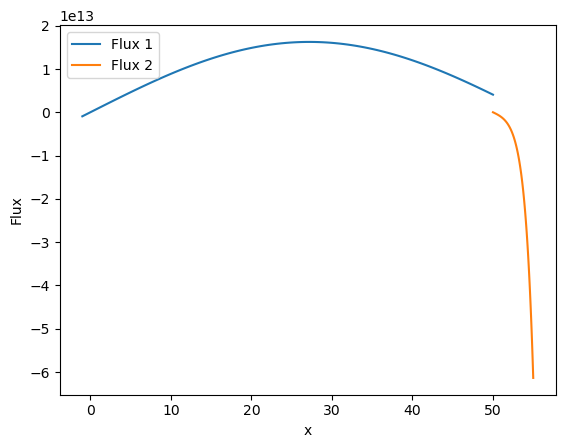

In [17]:
# Get phi1 and phi2 from solution
# phi1 = solution[0][0]
# phi2 = solution[0][1]
# phi3 = solution[0][2]
from sympy import sin, sinh, cosh, tanh

# Extract phi1, phi2, and phi3 from solution
phi1 = 16243883537731.3*sin(0.0577763678160984*x)
phi2 = -930715795680.211*sinh(0.976333324543103*x - 48.8166662271552)
phi3 = 0 #2064363323787.3*sp.sinh(1.00807365802306*x - 50.4036829011532)/sp.tanh(1.00807365802306*x - 50.4036829011532) + 2064363323787.3*sp.cosh(1.00807365802306*x - 50.4036829011532)

fluxes_solved = [phi1, phi2, phi3]

# Display the results
for flux in fluxes_solved:
    display(Latex(f"${sp.latex(flux)}$"))

# Plot the results from x=0 to x=50
import numpy as np
import matplotlib.pyplot as plt
from sympy import lambdify



x_sym = sp.symbols('x')
x_1 = np.linspace(-1, 50, 100)
x_2 = np.linspace(50, 55, 100)
x_3 = np.linspace(100, 150, 100)
phi1_vals = [phi1.subs(x, val).evalf() for val in x_1]
phi2_vals = [phi2.subs(x, val).evalf() for val in x_2]
#phi3_vals = [phi3.subs(x, val).evalf() for val in x_3]

plt.plot(x_1, phi1_vals, label='Flux 1')
plt.plot(x_2, phi2_vals, label='Flux 2')
#plt.plot(x_3, phi3_vals, label='Flux 3')
plt.xlabel('x')
plt.ylabel('Flux')
plt.legend()
plt.show()